``` bash
python launch_ST_pdb.py -pdb 5awl.pdb -dir CLN025_500K_5awl_500ns_25_step_save -n CLN025 -eq_time_expl 10 -last_temp 500 -time 500 -temp_time 10
```

In [51]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import MDAnalysis as mda
import nglview as nv 
from scipy.ndimage import gaussian_filter1d
from cmcrameri import cm

import sys
#sys.path.append('/home/murail/Documents/Code/simulated_solvent_tempering/')
#from simulated_solvent_tempering import analysis
sys.path.append('/home/murail/Documents/Code/SST2/src')
import SST2.analysis.data_plot as data_plot
import SST2.analysis.trajectory as trajectory

In [52]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (5, 3.5)
plt.rcParams['figure.dpi'] = 100

custom = {"grid.linestyle": "dotted", "grid.color":"black", "axes.grid": True}
sns.set_theme(context="paper", style="ticks", rc=custom)
colorscale = cm.roma

- prepare ref pdb:

```
vmd 2O02.pdb
[atomselect top "not chain A P"] set chain O
[atomselect top "chain P"] set chain B
[atomselect top "not chain O and not altloc B C D"] writepdb 2O02_clean.pdb
quit

```

In [3]:
name = 'CLN025'

OUT_PATH = f'ST_CLN025_20_rung_5awl_2ps_friction_10_1'

ref_coor = [f'5awl.pdb']

ref_name = ref_coor[0][:4]

name_fig = f'{name}_st_20_friction_10_1'
OUT_FIG = 'fig'

start_pdb = f'{OUT_PATH}/{name}_explicit_equi.pdb'
first_pdb = f'{OUT_PATH}/{name}_explicit_equi.pdb'

max_graph_point = 50000
dt = 0.004

ref_Sel = "protein and chainID A"
pep_Sel = "protein and chainID A"

show_weights = True
use_only_300 = False

if not os.path.exists(OUT_FIG):
    os.makedirs(OUT_FIG)

time_ax_name = r"$Time\;(\mu s)$"

In [4]:
df_all = data_plot.read_ST_data(
    f'{OUT_PATH}/{name}_ST',
    dt=dt,
    fields=["Step", "Aim Temp (K)"], full_sep=",")

In [5]:
df_all.tail()

,Aim Temp (K),Step,Potential Energy (kJ/mole),Total Energy (kJ/mole),Temperature (K),Speed (ns/day),$Time\;(\mu s)$,Temp (K)
4999995,336.262,2499998000,-38442.032338,-30146.519997,340.984554,1730.0,9.999992,336.262
4999996,346.682,2499998500,-38145.932879,-29839.994029,341.413133,1730.0,9.999994,346.682
4999997,346.682,2499999000,-37942.993117,-29338.798177,353.672860,1730.0,9.999996,346.682
4999998,357.424,2499999500,-37633.872802,-28867.314886,360.346742,1730.0,9.999998,357.424
4999999,368.500,2500000000,-37195.831479,-28395.692738,361.727071,1730.0,10.000000,368.500


In [6]:
df_all.tail()

,Aim Temp (K),Step,Potential Energy (kJ/mole),Total Energy (kJ/mole),Temperature (K),Speed (ns/day),$Time\;(\mu s)$,Temp (K)
4999995,336.262,2499998000,-38442.032338,-30146.519997,340.984554,1730.0,9.999992,336.262
4999996,346.682,2499998500,-38145.932879,-29839.994029,341.413133,1730.0,9.999994,346.682
4999997,346.682,2499999000,-37942.993117,-29338.798177,353.672860,1730.0,9.999996,346.682
4999998,357.424,2499999500,-37633.872802,-28867.314886,360.346742,1730.0,9.999998,357.424
4999999,368.500,2500000000,-37195.831479,-28395.692738,361.727071,1730.0,10.000000,368.500


In [7]:
temp_list = df_all['Aim Temp (K)'].unique()
temp_num = len(temp_list)
min_temp = temp_list[0]
max_temp = temp_list[-1]
print(f' {temp_num} Temperature ladder, min={min_temp:.1f} max={max_temp:.1f}')

 20 Temperature ladder, min=280.0 max=500.0


In [8]:
[round(temp, 1) for temp in temp_list]

[280.0,
 288.7,
 297.6,
 306.8,
 316.4,
 326.2,
 336.3,
 346.7,
 357.4,
 368.5,
 379.9,
 391.7,
 403.8,
 416.3,
 429.2,
 442.5,
 456.3,
 470.4,
 485.0,
 500.0]

## Exchange probability & Round trip time


Temp change freq   = 0.477
Round trip time is = 5.394 ns 


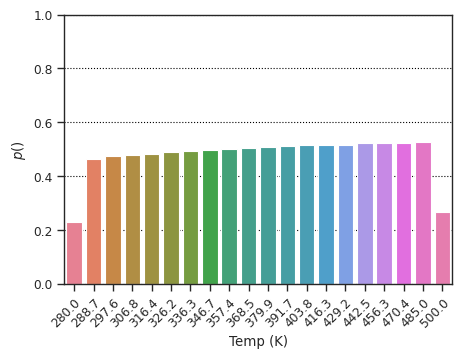

In [9]:
ex_prob, trip_time = data_plot.compute_exchange_prob(
    df_all,
    exchange_time=2,
    temp_col='Temp (K)')

plt.ylim(0,1)
plt.xticks(
    range(len(temp_list)),
    [round(temp, 1) for temp in temp_list],
    rotation=45,
    ha="right",
    rotation_mode="anchor")

print(f'Temp change freq   = {ex_prob:.3f}')
print(f"Round trip time is = {trip_time:.3f} ns ")

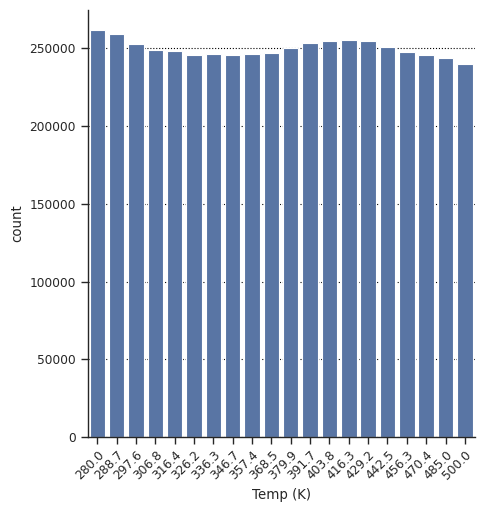

In [20]:
sns.catplot(df_all,
            x="Temp (K)",
            kind="count")
plt.xticks(
    range(len(temp_list)),
    [round(temp, 1) for temp in temp_list],
    rotation=45,
    ha="right",
    rotation_mode="anchor")
plt.savefig(f'{OUT_FIG}/{name_fig}_rung_dens.png')

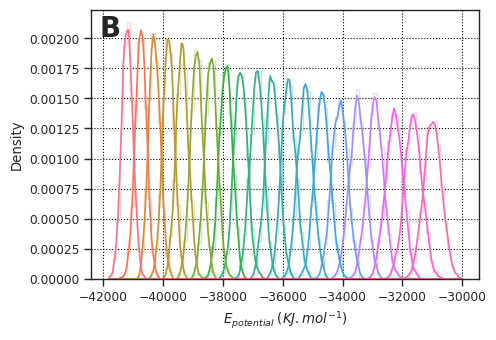

In [21]:
x_list = ["Potential Energy (kJ/mole)"]

x_label_list = [
    r'$E_{potential}\; (KJ.mol^{-1})$'
]

for x, x_label in zip(x_list, x_label_list):
    ax = data_plot.plot_distri_norm(
        df_all, 
        x=x,
        hue="Temp (K)",
        x_label=x_label)
    ax.text(0.02, 0.90, "B", transform=ax.transAxes, 
                size=20, weight='bold')
    ax.get_legend().remove()
    plt.savefig(f'{OUT_FIG}/{name_fig}_e_pot_distri.pdf', dpi=300, bbox_inches='tight')

<AxesSubplot: xlabel='$Time\\;(\\mu s)$', ylabel='Aim Temp (K)'>

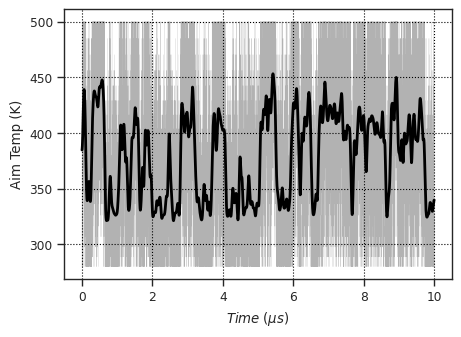

In [25]:
data_plot.plot_lineplot_avg(
    df_all,
    x=time_ax_name,
    y='Aim Temp (K)',
    max_data=max_graph_point,
    avg_win=100)

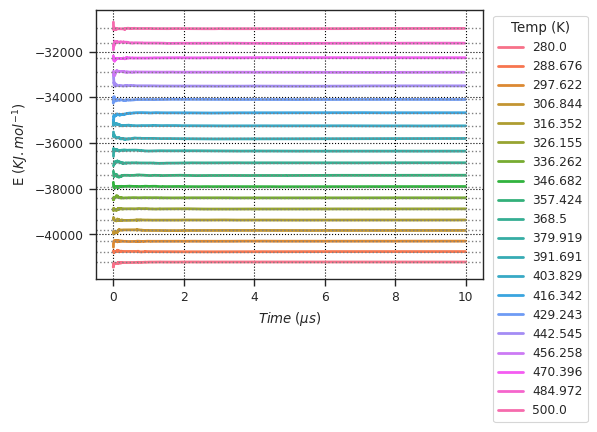

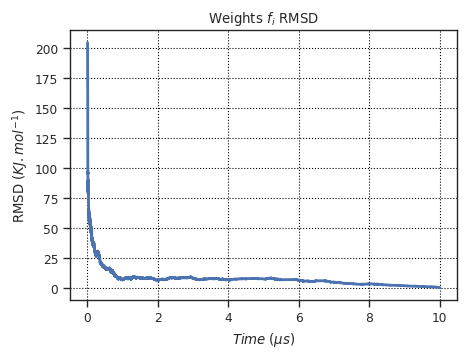

In [27]:
if show_weights:
    data_plot.plot_weight_RMSD(df_all, ener="Potential Energy (kJ/mole)", plot_weights=True)

### Save only every 10 steps

```
mdconvert villin_10_micros_sim_temp_fly/villin_sim_temp.dcd -o villin_10_micros_sim_temp_fly/villin_sim_temp_skip100.xtc -s 20
```

In [28]:
md = trajectory.read_traj(
    start_pdb,
    f'{OUT_PATH}/{name}_ST')

md_noh = md.select_atoms("protein and not name H*")

In [29]:
print(f'traj len : {len(md.trajectory)}')
print(f'all csv  : {len(df_all)}')

traj len : 250000
all csv  : 5000000


In [30]:
df_all = df_all[::20].reset_index()

In [31]:
print(f'traj len : {len(md.trajectory)}')
print(f'all csv  : {len(df_all)}')

max_step = min([len(md.trajectory), len(df_all)])
print(f'Max step = {max_step}')

df_all = df_all[:max_step]
step_300K_index = np.where(df_all['Aim Temp (K)'] == min_temp)[0]
print(len(step_300K_index))

traj len : 250000
all csv  : 250000
Max step = 250000
12959


In [32]:
steps_num = len(step_300K_index)

md_step = 1

while steps_num > max_graph_point:
    md_step += 1
    steps_num = len(step_300K_index) // md_step

print(md_step, len(step_300K_index) // md_step)

1 12959


In [33]:
md_noh.write(f'{OUT_PATH}/noh_300K_skip.pdb',
             frames=md.trajectory[:1])
if use_only_300:
    md_noh.write(f'{OUT_PATH}/noh_300K_skip.xtc',
                 frames=md.trajectory[step_300K_index][::md_step],
                 verbose=True)
    traj_filter = f'{OUT_PATH}/noh_300K_skip.xtc'
    df_300 = df_all.loc[step_300K_index][::md_step]
    df_300.to_csv(f'{OUT_PATH}/300K_data.csv', index=False, index_label=None)

/home/murail/miniconda3/envs/openmm2/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1129: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"


In [34]:
if not use_only_300:
    steps_num = len(md.trajectory)

    md_step = 1

    while steps_num > max_graph_point:
        md_step += 1
        steps_num = len(md.trajectory) // md_step

    print(md_step, steps_num)

    df_300 = df_all.loc[:max_step:md_step].reset_index()
    df_300.to_csv(f'{OUT_PATH}/all_data.csv', index=False, index_label=None)

    print(len(df_300))
    
    md_noh.write(f'{OUT_PATH}/noh_skip.xtc',
             frames=md.trajectory[:max_step:md_step],
             verbose=True)
    traj_filter = f'{OUT_PATH}/noh_skip.xtc'

5 50000
50000


In [ ]:
#%%time
#%%bash -s "$start_pdb" "$traj_xtc" "$md_step" "$out_pre" "$max_step"
#echo $1 $2 $3 $4 $5
#vmd -e filter_xtc.tcl -dispdev text -args $1 $2 $3 $4 $5

In [35]:
ref = mda.Universe(*ref_coor)

import openmm.app as app

pdbfile = app.PDBFile(f'{OUT_PATH}/noh_300K_skip.pdb')

md = mda.Universe(pdbfile,
                  traj_filter,
                  in_memory=True)

/home/murail/miniconda3/envs/openmm2/lib/python3.10/site-packages/MDAnalysis/coordinates/XDR.py:237: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn("Reload offsets from trajectory\n "


In [36]:
print(f'traj len : {len(md.trajectory)}')
print(f'all csv  : {len(df_300)}')


traj len : 50000
all csv  : 50000


In [37]:
trajectory.prepare_traj(md, ref_Sel)
trajectory.align_traj(md, ref, ref_Sel, tol_mass=10.0)
trajectory.align_traj(ref, ref, ref_Sel, tol_mass=10.0)

IntProgress(value=0, max=50000)

/home/murail/miniconda3/envs/openmm2/lib/python3.10/site-packages/MDAnalysis/core/groups.py:440: DeprecationWarning: The 'pbc' kwarg has been deprecated and will be removed in version 3.0., please use 'wrap' instead
  warnings.warn("The 'pbc' kwarg has been deprecated and will be "


  0%|          | 0/50000 [00:00<?, ?it/s]

/home/murail/miniconda3/envs/openmm2/lib/python3.10/site-packages/MDAnalysis/core/universe.py:641: UserWarning: Reader has no dt information, set to 1.0 ps
  dt=self.trajectory.ts.dt * step,


  0%|          | 0/1 [00:00<?, ?it/s]

In [38]:
import MDAnalysis.analysis.rms

R = MDAnalysis.analysis.rms.RMSD(
        md,
        ref,
        select=f"backbone and ({ref_Sel})",
        groupselections=[f"backbone and ({pep_Sel})"],
        verbose=True)
R.run()

rmsd = R.results.rmsd.T
df_300['RMSD (nm)'] = rmsd[3] / 10

  0%|          | 0/50000 [00:00<?, ?it/s]

<AxesSubplot: xlabel='$Time\\;(\\mu s)$', ylabel='RMSD (nm)'>

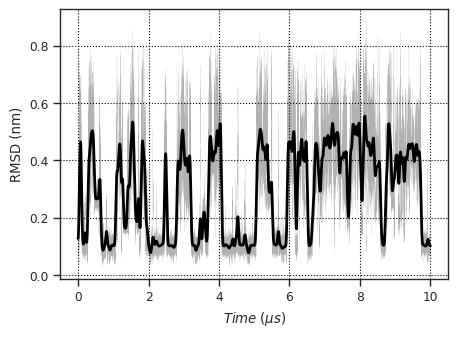

In [40]:
data_plot.plot_lineplot_avg(
    df_300,
    x=time_ax_name,
    y="RMSD (nm)",
    avg_win=100)

<AxesSubplot: xlabel='$Time\\;(\\mu s)$', ylabel='Aim Temp (K)'>

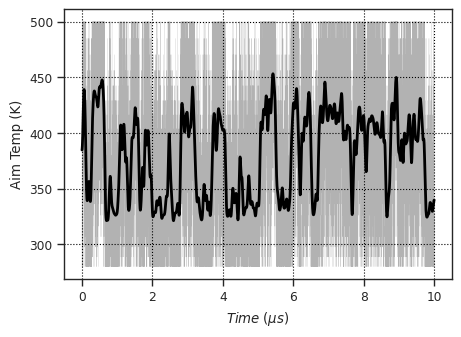

In [41]:
data_plot.plot_lineplot_avg(
    df_300,
    x=time_ax_name,
    y='Aim Temp (K)',
    max_data=max_graph_point,
    avg_win=100)

In [42]:
first_md = mda.Universe(first_pdb,
                        in_memory=True)

CA_pep_ref = first_md.select_atoms(f"({pep_Sel}) and name CA")
ref_com = CA_pep_ref.center_of_mass()
print("Ref Com",ref_com)

CA_pep = md.select_atoms(f"({pep_Sel}) and name CA")

com_dist = []

for ts in md.trajectory:
    #print("Frame: {0:5d}, Time: {1:8.3f} ps".format(ts.frame, md.trajectory.time))
    com = CA_pep.center_of_mass()
    com_dist.append(np.linalg.norm(ref_com - com))

df_300['COM dist (Å)'] = com_dist

/home/murail/miniconda3/envs/openmm2/lib/python3.10/site-packages/MDAnalysis/core/universe.py:641: UserWarning: Reader has no dt information, set to 1.0 ps
  dt=self.trajectory.ts.dt * step,


Ref Com [12.21609993 20.00219994  9.39739995]


In [45]:
com_dist_show = False

if com_dist_show:
    df_300['COM dist (Å)'] = com_dist
    df_300['COM_dist_sig6'] = gaussian_filter1d(df_300["COM dist (Å)"], 50)

    ax = sns.scatterplot(
        data=df_300,
        x=time_ax_name,
        y='COM dist (Å)',
        linewidth=0, s=2)

    ax = sns.scatterplot(
        data=df_300,
        x=time_ax_name,
        y="COM_dist_sig6",
        linewidth=0, s=2)

## Gyration radius

In [46]:
pep = md.select_atoms(f"({pep_Sel})")

gyr = []

for ts in md.trajectory:
    #print("Frame: {0:5d}, Time: {1:8.3f} ps".format(ts.frame, md.trajectory.time))
    gyr.append(pep.radius_of_gyration())

df_300['Gyration radius (nm)'] = [i/10 for i in gyr]

Text(0, 0.5, 'Gyration radius (nm)')

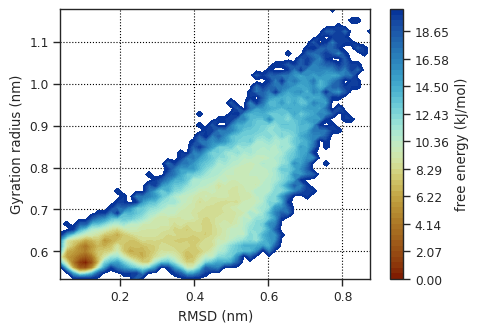

In [53]:
data_plot.plot_free_energy(
    df_300["RMSD (nm)"],
    df_300['Gyration radius (nm)'], 
    ncontours=50,
    cmap=colorscale,
    nbins=50)
plt.xlabel("RMSD (nm)")
plt.ylabel('Gyration radius (nm)')

## Fraction of native contact

In [54]:
df_300['Native Contact'] = trajectory.compute_native_contact(md, ref, 'protein and not name H*')

  0%|          | 0/50000 [00:00<?, ?it/s]

/home/murail/miniconda3/envs/openmm2/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)


<AxesSubplot: xlabel='$Time\\;(\\mu s)$', ylabel='Native Contact'>

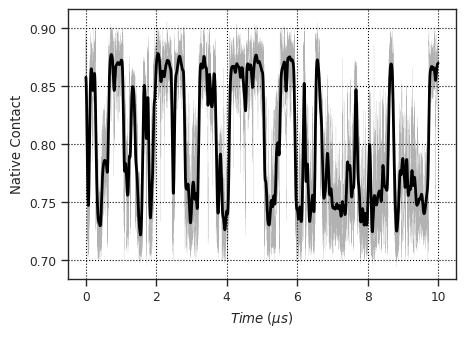

In [55]:
data_plot.plot_lineplot_avg(
    df_300,
    x=time_ax_name,
    y='Native Contact',
    avg_win=100)

Text(0, 0.5, 'Native contact')

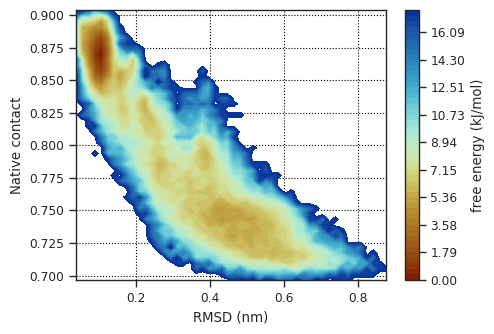

In [60]:
data_plot.plot_free_energy(
    df_300["RMSD (nm)"],
    df_300['Native Contact'], 
    ncontours=50,
    nbins=50,
    cmap=colorscale,
)
plt.xlabel("RMSD (nm)")
plt.ylabel('Native contact')

<AxesSubplot: xlabel='$Time\\;(\\mu s)$', ylabel='Potential Energy (kJ/mole)'>

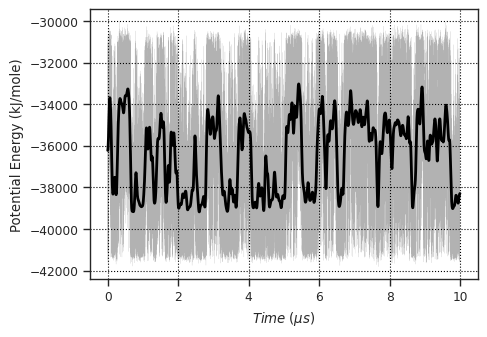

In [61]:
data_plot.plot_lineplot_avg(
    df_300,
    x=time_ax_name,
    y="Potential Energy (kJ/mole)",
    avg_win=100)

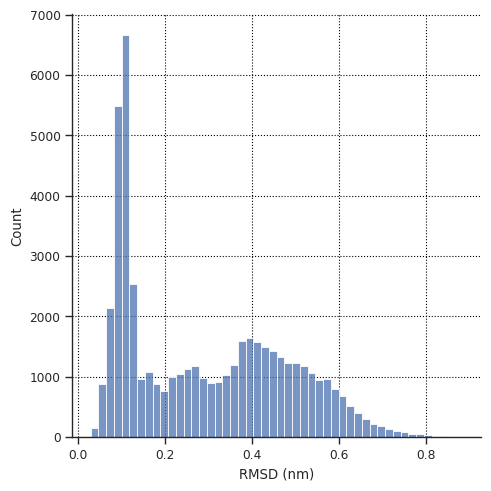

In [62]:
ax = sns.displot(df_300["RMSD (nm)"])

## Compute PCA

  0%|          | 0/50000 [00:00<?, ?it/s]

/home/murail/miniconda3/envs/openmm2/lib/python3.10/site-packages/MDAnalysis/analysis/pca.py:337: DeprecationWarning: The `cumulated_variance` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.cumulated_variance` instead.
  warnings.warn(wmsg, DeprecationWarning)


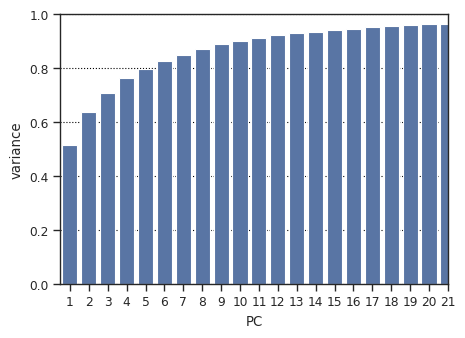

In [63]:
prot_pca, pca_df, pca_ref_df = trajectory.compute_pca(md, ref, sel='backbone', cum_var=0.8)
df_300['PC_1'] = pca_df['PC_1']
df_300['PC_2'] = pca_df['PC_2']

## Plot density for PC 1-2

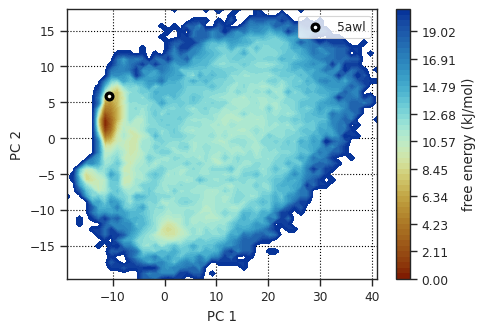

In [65]:
data_plot.plot_free_energy(
    pca_df.PC_1,
    pca_df.PC_2,
    nbins=50,
    ncontours=50,
    cmap=colorscale,
)

plt.scatter(pca_ref_df.PC_1, pca_ref_df.PC_2,
            color='white', s=5, linewidth=5,
            edgecolor = 'black',
            label=ref_name)
plt.legend()
plt.xlabel('PC 1')
plt.ylabel('PC 2')

plt.savefig(f'{OUT_FIG}/{name_fig}_PC_1_2_free_ener.png', dpi=300)

## Clustering with HDBSCAN

In [70]:
df_300['clust'] = data_plot.compute_cluster_hdbscan(pca_df)

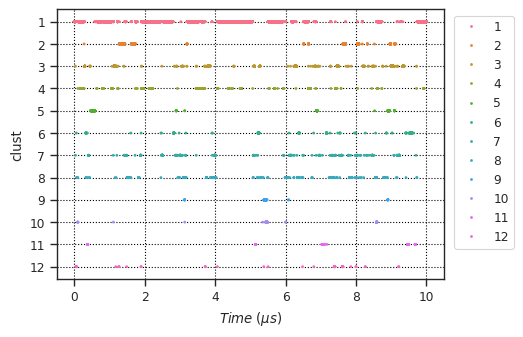

In [71]:
ax = sns.scatterplot(
    data=df_300,
    x=time_ax_name,
    y="clust",
    hue='clust',
    linewidth=0.0, s=4)
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.legend(bbox_to_anchor=(1.01, 1.00), loc=2)

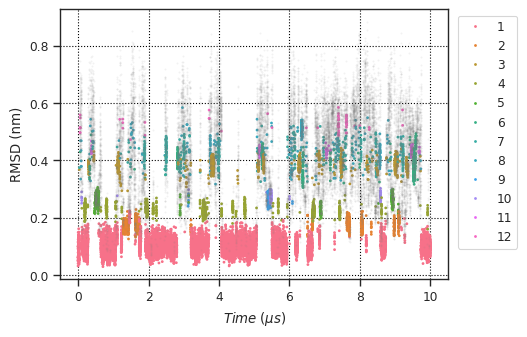

In [72]:
ax = sns.scatterplot(
    data=df_300,
    x=time_ax_name,
    y="RMSD (nm)",
    hue='clust',
    linewidth=0.0, s=4)

sns.scatterplot(
    data=df_300[df_300['clust'].isnull()],
    x=time_ax_name,
    y="RMSD (nm)",
    color='gray',
    alpha=0.1,
    linewidth=0.0, s=2)

ax.legend(bbox_to_anchor=(1.01, 1.0), loc=2)

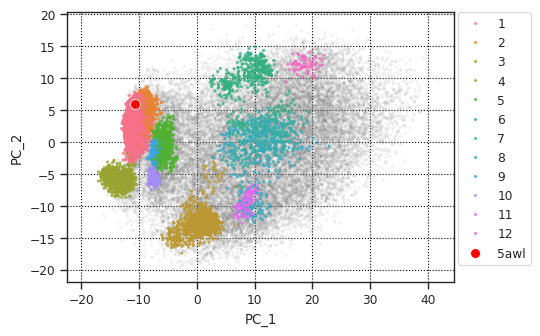

In [73]:
plt.figure()

sns.scatterplot(data=df_300[df_300.clust.isnull()],
                x="PC_1", y="PC_2",
                color='gray', s=5,
                linewidth=0,
                alpha=0.1)

sns.scatterplot(data=df_300,
                x="PC_1", y="PC_2",
                hue="clust",
                s=5,
                alpha=0.8,
                linewidth=0)

sns.scatterplot(
    data=pca_ref_df,
    x="PC_1",
    y="PC_2",
    s=50, label=ref_name,
    color='red')
#plt.scatter(pca_df.PC_1[1], pca_df.PC_2[1],
#            color='gray', label='3PXR')

plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

plt.savefig(f'{OUT_FIG}/{name_fig}_PC_1_2_clust.png')

In [74]:
df_300

,level_0,index,Aim Temp (K),Step,Potential Energy (kJ/mole),Total Energy (kJ/mole),Temperature (K),Speed (ns/day),$Time\;(\mu s)$,Temp (K),...,Time change,Energie Diff,RMSD (nm),COM dist (Å),COM_dist_sig6,Gyration radius (nm),Native Contact,PC_1,PC_2,clust
0,0,0,280.000,500,-41386.529432,-34529.702880,281.847805,0.0,0.000002,280.000,...,2.0,-193.318760,0.031812,6.981225,6.956224,0.608399,0.896246,-10.817899,6.371139,1
1,5,100,280.000,50500,-41467.796745,-34603.367603,282.160307,1730.0,0.000202,280.000,...,-8.0,-274.586073,0.061739,6.939612,6.956222,0.625424,0.891778,-11.427039,5.545442,1
2,10,200,429.243,100500,-34222.526924,-24044.255011,418.374823,1730.0,0.000402,429.243,...,2.0,-119.689661,0.040566,6.919191,6.956220,0.630542,0.889242,-11.162593,6.311691,1
3,15,300,470.396,150500,-32193.940342,-20513.441453,480.123414,1730.0,0.000602,470.396,...,-6.0,84.629980,0.049158,6.931125,6.956217,0.625269,0.891080,-10.961255,4.676320,1
4,20,400,403.829,200500,-35202.133701,-25430.235583,401.670950,1720.0,0.000802,403.829,...,4.0,47.783564,0.055031,7.027142,6.956214,0.617293,0.899821,-11.067670,5.585951,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,249975,4999500,357.424,2499750500,-37639.444849,-29244.589635,345.068013,1730.0,9.999002,357.424,...,2.0,-244.860380,0.066936,6.928678,6.957115,0.567149,0.876179,-10.679352,3.642543,1
49996,249980,4999600,288.676,2499800500,-40871.984410,-33870.604815,287.789615,1730.0,9.999202,288.676,...,2.0,-126.432576,0.099787,6.941873,6.957134,0.561383,0.883624,-10.887597,2.626967,1
49997,249985,4999700,280.000,2499850500,-40979.915194,-33986.013901,287.482221,1730.0,9.999402,280.000,...,-2.0,213.295478,0.108393,6.964843,6.957148,0.574147,0.883168,-11.347328,2.616164,1
49998,249990,4999800,297.622,2499900500,-40010.829313,-32579.388947,305.467134,1730.0,9.999602,297.622,...,-2.0,280.981977,0.077362,6.998554,6.957158,0.568635,0.881323,-10.924701,3.559235,1


<AxesSubplot: xlabel='PC_1', ylabel='PC_2'>

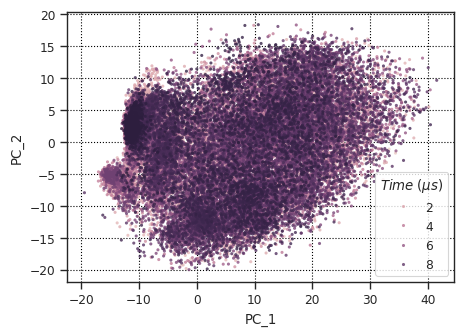

In [75]:
sns.scatterplot(data=df_300,
                x="PC_1", y="PC_2",
                hue=time_ax_name,
                s=5,
                alpha=0.8,
                linewidth=0)

In [76]:
center_frame = []

dt = md.trajectory.dt

md_noh = md.select_atoms(f"protein and not name H* and ({pep_Sel})")
md_noh.write("tmp_ref.pdb")

ref_tmp = mda.Universe('tmp_ref.pdb')
ref_sel = ref_tmp.select_atoms(f"protein and not name H* and ({pep_Sel})")

n_clusters_ = len(df_300['clust'].unique())

for clust in range(1, n_clusters_ + 1):
    indexes = [i for i, val in enumerate(df_300['clust']) if val==clust]
    print(f'Cluster : {clust:3}, num: {len(indexes):6}')
    
    # Compute avg structures:
    p_avg = np.zeros_like(md_noh.atoms.positions)

    # do a quick average of the protein (in reality you probably want to remove PBC and RMSD-superpose)
    for ts in md.trajectory[indexes]:
        p_avg += md_noh.atoms.positions
    p_avg /= len(indexes)
    ref_sel.atoms.positions = p_avg
    
    min_rmsd = np.inf
    step = 0
    frame = 0
    for ts in md.trajectory[indexes]:
        R = mda.analysis.rms.rmsd(md_noh.atoms.positions, ref_sel.atoms.positions)
        if R<min_rmsd:
            min_rmsd = R
            frame = ts.frame
            time= ts.time
    
    md_noh.write(f'{OUT_PATH}/clust_{clust}.pdb',
             frames=md.trajectory[frame:frame+1])
    
    local_df = df_300[df_300.clust == clust]
    
    print(f'\t closest structure : {frame:6},   size= {len(indexes):6}   RMSD={local_df["RMSD (nm)"].mean():.2f}')
    center_frame.append([clust, frame, len(indexes)])

/home/murail/miniconda3/envs/openmm2/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1129: UserWarning: Found no information for attr: 'altLocs' Using default value of ' '
  warnings.warn("Found no information for attr: '{}'"
/home/murail/miniconda3/envs/openmm2/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1129: UserWarning: Found no information for attr: 'icodes' Using default value of ' '
  warnings.warn("Found no information for attr: '{}'"
/home/murail/miniconda3/envs/openmm2/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1129: UserWarning: Found no information for attr: 'occupancies' Using default value of '1.0'
  warnings.warn("Found no information for attr: '{}'"
/home/murail/miniconda3/envs/openmm2/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1129: UserWarning: Found no information for attr: 'tempfactors' Using default value of '0.0'
  warnings.warn("Found no information for attr: '{}'"
/home/murail/miniconda3/envs/openmm2/lib/

Cluster :   1, num:  18641


/home/murail/miniconda3/envs/openmm2/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1129: UserWarning: Found no information for attr: 'altLocs' Using default value of ' '
  warnings.warn("Found no information for attr: '{}'"
/home/murail/miniconda3/envs/openmm2/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1129: UserWarning: Found no information for attr: 'icodes' Using default value of ' '
  warnings.warn("Found no information for attr: '{}'"
/home/murail/miniconda3/envs/openmm2/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1129: UserWarning: Found no information for attr: 'occupancies' Using default value of '1.0'
  warnings.warn("Found no information for attr: '{}'"
/home/murail/miniconda3/envs/openmm2/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1129: UserWarning: Found no information for attr: 'tempfactors' Using default value of '0.0'
  warnings.warn("Found no information for attr: '{}'"
/home/murail/miniconda3/envs/openmm2/lib/

	 closest structure :  24742,   size=  18641   RMSD=0.10
Cluster :   2, num:   1614
	 closest structure :   6689,   size=   1614   RMSD=0.17
Cluster :   3, num:   1150
	 closest structure :   5653,   size=   1150   RMSD=0.39
Cluster :   4, num:   1075
	 closest structure :  37131,   size=   1075   RMSD=0.23
Cluster :   5, num:    512
	 closest structure :  44540,   size=    512   RMSD=0.26
Cluster :   6, num:    411
	 closest structure :  14130,   size=    411   RMSD=0.40
Cluster :   7, num:    388
	 closest structure :  37055,   size=    388   RMSD=0.43
Cluster :   8, num:    312
	 closest structure :  18759,   size=    312   RMSD=0.45
Cluster :   9, num:    181
	 closest structure :  27007,   size=    181   RMSD=0.26
Cluster :  10, num:    123
	 closest structure :  27308,   size=    123   RMSD=0.28
Cluster :  11, num:    100
	 closest structure :   1914,   size=    100   RMSD=0.43
Cluster :  12, num:     67
	 closest structure :  38081,   size=     67   RMSD=0.53
Cluster :  13, num:

/home/murail/miniconda3/envs/openmm2/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1129: UserWarning: Found no information for attr: 'altLocs' Using default value of ' '
  warnings.warn("Found no information for attr: '{}'"
/home/murail/miniconda3/envs/openmm2/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1129: UserWarning: Found no information for attr: 'icodes' Using default value of ' '
  warnings.warn("Found no information for attr: '{}'"
/home/murail/miniconda3/envs/openmm2/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1129: UserWarning: Found no information for attr: 'occupancies' Using default value of '1.0'
  warnings.warn("Found no information for attr: '{}'"
/home/murail/miniconda3/envs/openmm2/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1129: UserWarning: Found no information for attr: 'tempfactors' Using default value of '0.0'
  warnings.warn("Found no information for attr: '{}'"
/home/murail/miniconda3/envs/openmm2/lib/

In [77]:
df_300[(df_300.clust==1) & (df_300["RMSD (nm)"]<0.2)].tail(100)

,level_0,index,Aim Temp (K),Step,Potential Energy (kJ/mole),Total Energy (kJ/mole),Temperature (K),Speed (ns/day),$Time\;(\mu s)$,Temp (K),...,Time change,Energie Diff,RMSD (nm),COM dist (Å),COM_dist_sig6,Gyration radius (nm),Native Contact,PC_1,PC_2,clust
49899,249495,4989900,326.155,2494950500,-39296.530595,-31517.691748,319.746845,1730.0,9.979802,326.155,...,2.0,-411.481177,0.095296,6.920854,6.952531,0.568538,0.877314,-10.875879,1.820944,1
49900,249500,4990000,326.155,2495000500,-38645.251895,-30457.972690,336.535663,1730.0,9.980002,326.155,...,-2.0,239.797523,0.080721,6.914984,6.952431,0.564962,0.882881,-11.439919,2.914374,1
49901,249505,4990100,391.691,2495050500,-35726.017883,-26310.695505,387.014011,1730.0,9.980202,391.691,...,4.0,77.050401,0.128210,6.866208,6.952334,0.571504,0.864364,-11.313805,0.404822,1
49902,249510,4990200,288.676,2495100500,-40363.443204,-32972.463183,303.804024,1730.0,9.980402,288.676,...,-2.0,382.108629,0.093973,6.985970,6.952240,0.572784,0.862667,-11.525550,2.250064,1
49903,249515,4990300,326.155,2495150500,-39128.054629,-31353.223053,319.582127,1730.0,9.980602,326.155,...,2.0,-243.005211,0.095855,6.931814,6.952150,0.577147,0.866072,-11.793594,2.242812,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,249975,4999500,357.424,2499750500,-37639.444849,-29244.589635,345.068013,1730.0,9.999002,357.424,...,2.0,-244.860380,0.066936,6.928678,6.957115,0.567149,0.876179,-10.679352,3.642543,1
49996,249980,4999600,288.676,2499800500,-40871.984410,-33870.604815,287.789615,1730.0,9.999202,288.676,...,2.0,-126.432576,0.099787,6.941873,6.957134,0.561383,0.883624,-10.887597,2.626967,1
49997,249985,4999700,280.000,2499850500,-40979.915194,-33986.013901,287.482221,1730.0,9.999402,280.000,...,-2.0,213.295478,0.108393,6.964843,6.957148,0.574147,0.883168,-11.347328,2.616164,1
49998,249990,4999800,297.622,2499900500,-40010.829313,-32579.388947,305.467134,1730.0,9.999602,297.622,...,-2.0,280.981977,0.077362,6.998554,6.957158,0.568635,0.881323,-10.924701,3.559235,1


In [78]:
view = nv.show_mdanalysis(md)
view.add_component(ref_coor[0])
view.clear_representations(1)
view[1].add_cartoon(selection="protein", color='blue')
view[1].add_licorice(selection=":A", color='blue')
view[0].add_licorice(selection=":A")

from ipywidgets import interact

def update(n):
    
    local_df = df_300[df_300.clust == n]
    
    view.frame = center_frame[n-1][1]
    print(f"Cluster {n}, size={center_frame[n-1][2]}, frame={center_frame[n-1][1]}, RMSD={local_df['RMSD (nm)'].mean():.2f}")

interact(update, n=range(1, len(center_frame)+1));

view

interactive(children=(Dropdown(description='n', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13), value=1),…

NGLWidget(frame=24742, max_frame=49999)

In [79]:
from MDAnalysis.analysis import diffusionmap

matrix = diffusionmap.DistanceMatrix(md, select=f'backbone and ({pep_Sel})',
                                     verbose=True, pairwise_align=False).run(step=20)

  0%|          | 0/2500 [00:00<?, ?it/s]

/home/murail/miniconda3/envs/openmm2/lib/python3.10/site-packages/MDAnalysis/analysis/diffusionmap.py:288: DeprecationWarning: The `dist_matrix` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.dist_matrix` instead.
  warnings.warn(wmsg, DeprecationWarning)


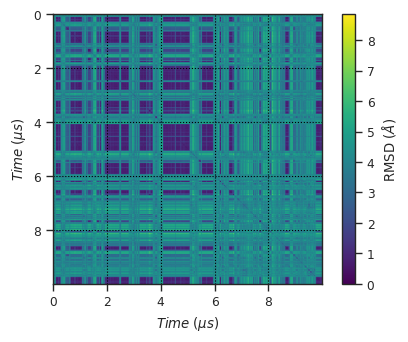

In [80]:
# WARNING: time is not continuous as only 300K frames are shown

max_RMSD = df_300["RMSD (nm)"].max() * 10 # Angstrom

last_time = df_300.iloc[-1][time_ax_name]

plt.imshow(matrix.dist_matrix,
           cmap='viridis',
           vmax=max_RMSD,
           extent=[0, last_time, last_time, 0])
plt.xlabel(time_ax_name)
plt.ylabel(time_ax_name)
plt.colorbar(label=r'RMSD ($\AA$)')

In [81]:
print(f"vmd {OUT_PATH}/noh_300K_skip.pdb {traj_filter}"\
      f" -m ../REST2_test/{ref_coor[0]} -e ../REST2_test/visualize_pep.tcl")

vmd ST_CLN025_20_rung_5awl_2ps_friction_10_1/noh_300K_skip.pdb ST_CLN025_20_rung_5awl_2ps_friction_10_1/noh_skip.xtc -m ../REST2_test/5awl.pdb -e ../REST2_test/visualize_pep.tcl


280.0 2555
288.676 2693
297.622 2560
306.844 2447
316.352 2428
326.155 2473
336.262 2498
346.682 2463
357.424 2389
368.5 2502
379.919 2598
391.691 2412
403.829 2569
416.342 2651
429.243 2590
442.545 2432
456.258 2501
470.396 2430
484.972 2407
500.0 2402


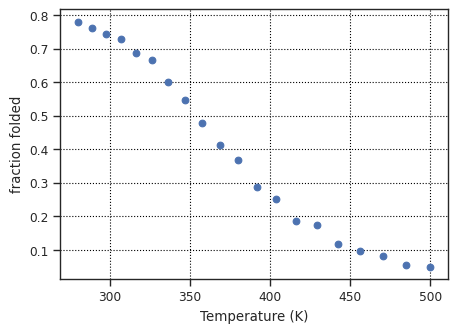

In [82]:
if not use_only_300:

    rmsd_cutoff = 0.18
    fold_frac = []

    for temp in temp_list:
        
        local_df = df_300[df_300["Aim Temp (K)"] == temp]
        
        num_frame = len(local_df)
        print(temp, num_frame)
        num_cutoff = sum(local_df["RMSD (nm)"] < rmsd_cutoff)
        
        if num_frame != 0:
            fold_frac.append(num_cutoff/num_frame)
        else:
            fold_frac.append(np.nan)
    
    plt.scatter(temp_list, fold_frac)
    plt.xlabel('Temperature (K)')
    plt.ylabel('fraction folded')
    plt.savefig(f'{OUT_FIG}/{name_fig}_fraction_folded.png')

<AxesSubplot: xlabel='$Time\\;(\\mu s)$', ylabel='RMSD (nm)'>

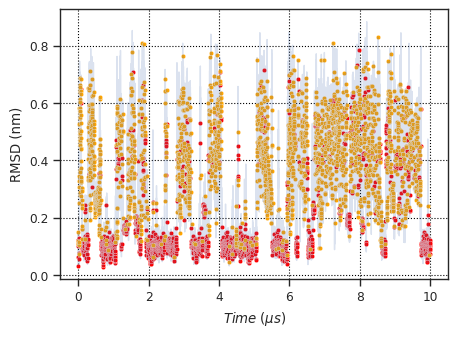

In [83]:
sns.lineplot(data=df_300,
             x=time_ax_name,
             y="RMSD (nm)", alpha=0.2, linewidth=1)
sns.scatterplot(data=df_300[df_300["Aim Temp (K)"] == temp_list[0]],
             x=time_ax_name, color='red', s=10,
             y="RMSD (nm)")
sns.scatterplot(data=df_300[df_300["Aim Temp (K)"] == temp_list[-1]],
             x=time_ax_name, color='orange', s=10,
             y="RMSD (nm)")

In [84]:
msd = False

if msd:

    from MDAnalysis.analysis.waterdynamics import MeanSquareDisplacement as MSD
    from scipy import stats

    tot_time = md.trajectory.dt * md.trajectory.n_frames
    print(f"Total simulation time should be {tot_time/1000:.2f} ns")

    lag_time = 20 #ns
    end_time = int(lag_time * 1000/md.trajectory.dt)

    MSD = MSD(md, pep_Sel, 0, md.trajectory.n_frames, end_time)
    MSD.run()

    dt = md.trajectory.dt
    time = np.arange(0.0, dt*len(MSD.timeseries), dt)

    start_time = 5 #ns
    start_frame = int(start_time * 1000/md.trajectory.dt)
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        time[start_frame:],MSD.timeseries[start_frame:])
    estimate = time*slope + intercept

    print("D (10-6 m**2/s) =", 1000*slope/0.6)

In [85]:
if msd:
    #Plot
    #sns.set_theme(style="ticks")

    plt.xlabel('time (ns)')
    plt.ylabel('MSD ($\\AA^2$)')
    plt.semilogy(time/1000, MSD.timeseries,
                 'ro', label=f"D = {1000*slope/0.6:.2f}"+"  $10^{-6}.m^2.s^{-1}$")
    plt.semilogy(time/1000, estimate, color="black", linestyle=":")
    plt.legend()
    plt.legend(bbox_to_anchor=(0.24, 0.55))
    plt.show()